# Lab Instructions

Choose your own adventure! In this lab, you will select a dataset, identify the target feature, and determine what relationships are present between the target and the other features in the data.

The dataset should have at least 5 features plus the target and at least a few hundred rows.  If the original dataset has more than 5 features, you may select the 5 that seem most interesting for this project. The subject can be anything you choose.  

For your lab submission, describe the dataset and the features - including all of the values of the features - and identify the target feature.  Then make visualizations to show the relationship of each feature to the target.  Which feature(s) seem most related?  Which features don't seem to influence the value of the target?  Draw at least one big picture conclusion about your data from the visualizations you've created.


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime

df = pd.read_csv('Starbucks_reviews.csv')

df.head()

,name,location,Date,Rating,Review,Image_Links
0,Helen,"Wichita Falls, TX","Reviewed Sept. 13, 2023",5.0,Amber and LaDonna at the Starbucks on Southwes...,['No Images']
1,Courtney,"Apopka, FL","Reviewed July 16, 2023",5.0,** at the Starbucks by the fire station on 436...,['No Images']
2,Daynelle,"Cranberry Twp, PA","Reviewed July 5, 2023",5.0,I just wanted to go out of my way to recognize...,['https://media.consumeraffairs.com/files/cach...
3,Taylor,"Seattle, WA","Reviewed May 26, 2023",5.0,Me and my friend were at Starbucks and my card...,['No Images']
4,Tenessa,"Gresham, OR","Reviewed Jan. 22, 2023",5.0,I’m on this kick of drinking 5 cups of warm wa...,['https://media.consumeraffairs.com/files/cach...


In [88]:
df.columns = [c.strip() for c in df.columns]
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

df['review_len_chars'] = df['Review'].fillna("").str.len()
df['review_len_words'] = df['Review'].fillna("").str.split().apply(len)


In [89]:
def parse_has_image(x):
    if pd.isna(x):
        return False
    s = str(x).lower()
    if 'no image' in s or 'no images' in s or s.strip() in ["", "[]"]:
        return False
    if 'http' in s or re.search(r'\.jpg|\.jpeg|\.png|\.gif', s):
        return True
    if s.strip() not in ["['no images']", "no images", "[]"]:
        return True
    return False
df['has_image'] = df['Image_Links'].apply(parse_has_image)

def parse_date(x):
    if pd.isna(x): 
        return pd.NaT
    s = str(x).strip()
    s = re.sub(r'^[Rr]eview(?:ed)?\s*', '', s)
    s = s.replace('.', '')
    for fmt in ("%b %d, %Y", "%B %d, %Y", "%b %d %Y", "%B %d %Y"):
        try:
            return pd.to_datetime(s, format=fmt)
        except Exception:
            pass
    return pd.to_datetime(s, errors='coerce')

df['date_parsed'] = df['Date'].apply(parse_date)
df['review_month'] = df['date_parsed'].dt.month
df['review_month_name'] = df['date_parsed'].dt.month_name()
df['review_dayofweek'] = df['date_parsed'].dt.day_name()

In [100]:
def extract_state(loc):
    if pd.isna(loc): return np.nan
    parts = [p.strip() for p in str(loc).split(',')]
    if len(parts) >= 2:
        st = parts[-1]
        m = re.search(r'([A-Za-z]{2})$', st)
        if m:
            return m.group(1).upper()
        return st
    return np.nan

df['state'] = df['location'].apply(extract_state)

summary = {}
summary['shape'] = df.shape
summary['rating_stats'] = df['Rating'].describe().to_dict()
summary['rating_value_counts'] = df['Rating'].value_counts(dropna=False).sort_index().to_dict()
summary['sample_rows'] = df.head(5).to_dict(orient='records')

print("DATASET SHAPE:", summary['shape'])
print("\nRATING STATS:\n", df['Rating'].describe())
print("\nRATING VALUE COUNTS:\n", df['Rating'].value_counts().sort_index())
print("\nSAMPLE ROWS:\n", df.head())

OUT_DIR = "starbucks_lab_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

needed_cols = ['review_len_chars', 'review_len_words', 'exclamation_count',
               'question_count', 'uppercase_ratio']

missing = [c for c in needed_cols if c not in df.columns]
if missing:
    print("Creating missing engineered columns:", missing)

if 'review_len_chars' not in df.columns:
    df['review_len_chars'] = df['Review'].fillna("").str.len()
if 'review_len_words' not in df.columns:
    df['review_len_words'] = df['Review'].fillna("").str.split().apply(len)

if 'exclamation_count' not in df.columns:
    df['exclamation_count'] = df['Review'].fillna("").str.count(r'!')
if 'question_count' not in df.columns:
    df['question_count'] = df['Review'].fillna("").str.count(r'\?')

def uppercase_ratio(s):
    if not s or len(s) == 0:
        return 0.0
    letters = re.sub(r'[^A-Za-z]', '', s)
    if len(letters) == 0:
        return 0.0
    return sum(1 for ch in letters if ch.isupper()) / len(letters)

if 'uppercase_ratio' not in df.columns:
    df['uppercase_ratio'] = df['Review'].fillna("").apply(uppercase_ratio)

if 'Rating' not in df.columns:
    raise KeyError("Missing 'Rating' column — cannot compute correlations.")
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

numeric_cols = ['Rating', 'review_len_chars', 'review_len_words', 'exclamation_count',
                'question_count', 'uppercase_ratio']

numdf = df[numeric_cols].copy().dropna()
if numdf.shape[0] == 0:
    raise ValueError("No rows remain after dropping NaNs for numeric columns. Check your data.")

corr = numdf.corr()

print("Correlation matrix computed for", numdf.shape[0], "rows. Saved to:",
      os.path.join(OUT_DIR, "corr_numeric_features.png"))
print(corr)

with open(os.path.join(OUT_DIR, "summary.txt"), "w", encoding="utf-8") as f:
    f.write("Dataset shape: {}\n\n".format(summary['shape']))
    f.write("Rating stats:\n{}\n\n".format(df['Rating'].describe().to_string()))
    f.write("Rating value counts:\n{}\n\n".format(df['Rating'].value_counts().sort_index().to_string()))
    f.write("Sample rows:\n{}\n".format(df.head().to_string()))

df.to_csv(os.path.join(OUT_DIR, "starbucks_reviews_engineered.csv"), index=False)


DATASET SHAPE: (850, 18)

RATING STATS:
 count    705.000000
mean       1.870922
std        1.397672
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        5.000000
Name: Rating, dtype: float64

RATING VALUE COUNTS:
 Rating
1.0    451
2.0     99
3.0     33
4.0     39
5.0     83
Name: count, dtype: int64

SAMPLE ROWS:
        name           location                     Date  Rating  \
0     Helen  Wichita Falls, TX  Reviewed Sept. 13, 2023     5.0   
1  Courtney         Apopka, FL   Reviewed July 16, 2023     5.0   
2  Daynelle  Cranberry Twp, PA    Reviewed July 5, 2023     5.0   
3    Taylor        Seattle, WA    Reviewed May 26, 2023     5.0   
4   Tenessa        Gresham, OR   Reviewed Jan. 22, 2023     5.0   

                                              Review  \
0  Amber and LaDonna at the Starbucks on Southwes...   
1  ** at the Starbucks by the fire station on 436...   
2  I just wanted to go out of my way to recognize...   
3  Me and my frie

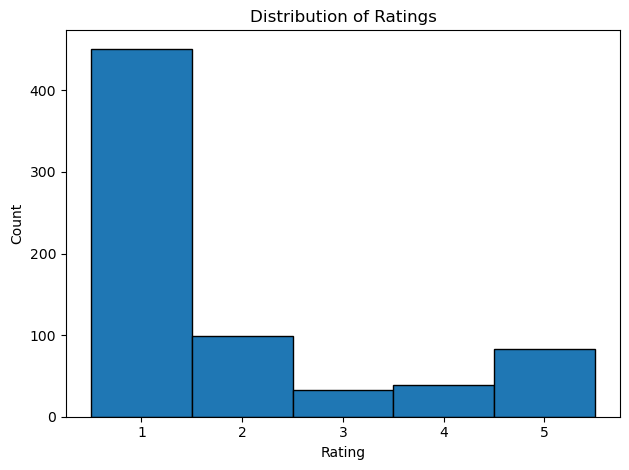

In [91]:
plt.figure()
plt.hist(df['Rating'].dropna(), bins=np.arange(0.5, 5.5+1, 1), edgecolor='black')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks([1,2,3,4,5])
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "hist_ratings.png"))
plt.show()

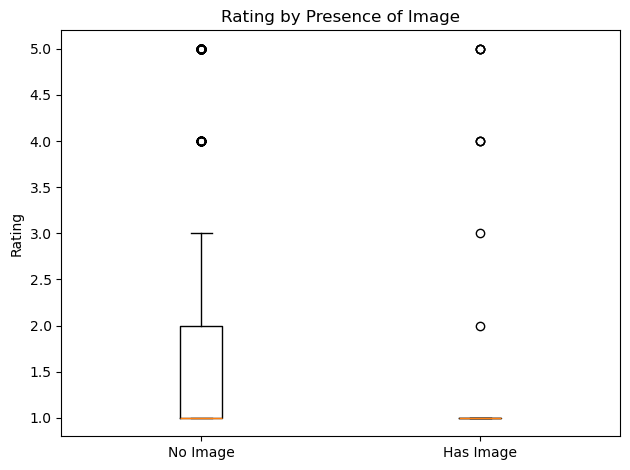

In [92]:
plt.figure()
has_img_grouped = [df.loc[df['has_image']==False, 'Rating'].dropna(),
                   df.loc[df['has_image']==True, 'Rating'].dropna()]
plt.boxplot(has_img_grouped, labels=['No Image', 'Has Image'])
plt.title("Rating by Presence of Image")
plt.ylabel("Rating")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "boxplot_rating_by_has_image.png"))
plt.show()

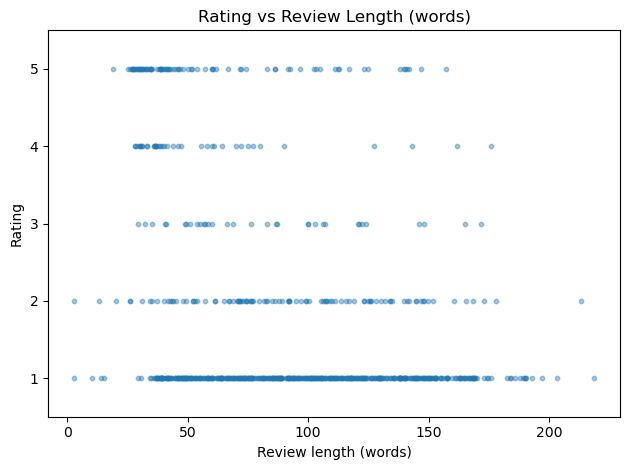

In [93]:
plt.figure()
x = df['review_len_words'].fillna(0)
y = df['Rating'].fillna(np.nan)
jitter = (np.random.rand(len(x)) - 0.5) * 0.6
plt.scatter(x + jitter, y, alpha=0.4, s=10)
plt.xlabel("Review length (words)")
plt.ylabel("Rating")
plt.title("Rating vs Review Length (words)")
plt.ylim(0.5, 5.5)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "scatter_rating_vs_review_length.png"))
plt.show()

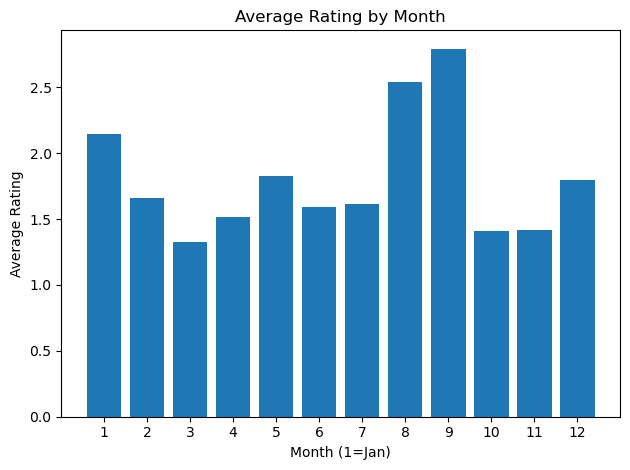

In [94]:
plt.figure()
month_order = list(range(1,13))
avg_by_month = df.groupby('review_month')['Rating'].mean().reindex(month_order)
plt.bar(range(1,13), avg_by_month.fillna(0))
plt.xlabel("Month (1=Jan)")
plt.ylabel("Average Rating")
plt.title("Average Rating by Month")
plt.xticks(range(1,13))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_rating_by_month.png"))
plt.show()

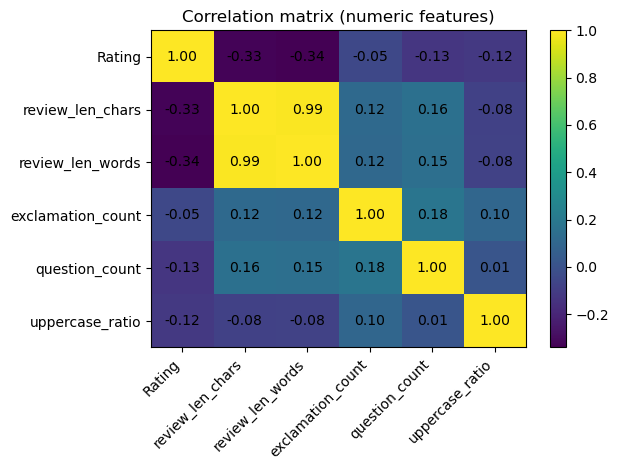

In [95]:
numeric_cols = ['Rating', 'review_len_chars', 'review_len_words', 'exclamation_count',
                'question_count', 'uppercase_ratio']
numdf = df[numeric_cols].copy().dropna()
corr = numdf.corr()
plt.figure()
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation matrix (numeric features)")
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f"{corr.iloc[i,j]:.2f}", ha='center', va='center', color='black')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "corr_numeric_features.png"))
plt.show()

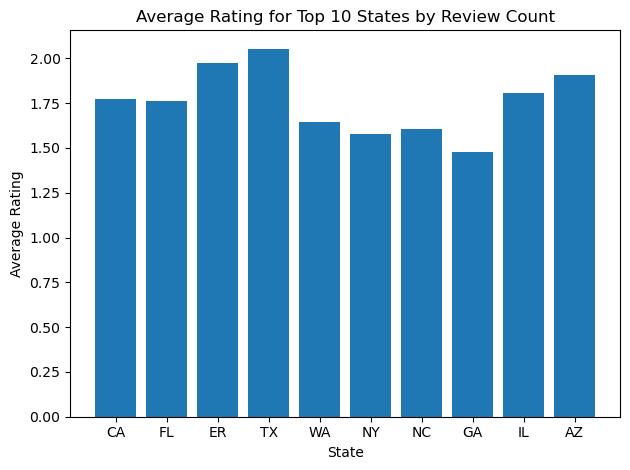

In [96]:
plt.figure()
state_counts = df['state'].value_counts().dropna()
top_states = state_counts.head(10).index.tolist()
avg_by_state = df[df['state'].isin(top_states)].groupby('state')['Rating'].mean().reindex(top_states)
plt.bar(range(len(top_states)), avg_by_state.fillna(0))
plt.xticks(range(len(top_states)), top_states)
plt.xlabel("State")
plt.ylabel("Average Rating")
plt.title("Average Rating for Top 10 States by Review Count")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "avg_rating_by_state_top10.png"))
plt.show()


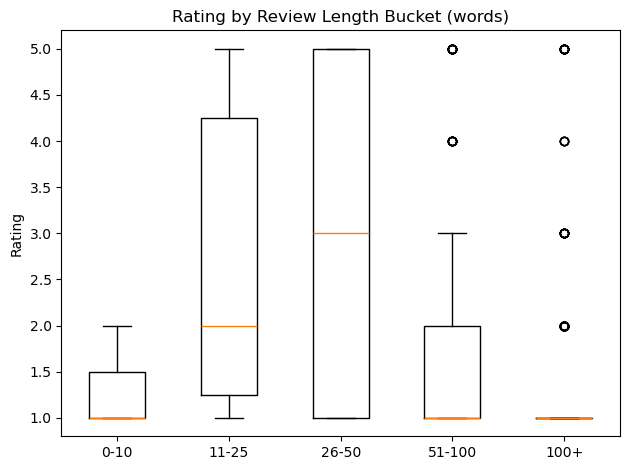

In [97]:
plt.figure()
df['review_len_words_bucket'] = pd.cut(df['review_len_words'], bins=[0,10,25,50,100,1000],
                                       labels=['0-10','11-25','26-50','51-100','100+'])
groups = [df.loc[df['review_len_words_bucket']==b, 'Rating'].dropna() for b in
          ['0-10','11-25','26-50','51-100','100+']]
plt.boxplot(groups, labels=['0-10','11-25','26-50','51-100','100+'])
plt.title("Rating by Review Length Bucket (words)")
plt.ylabel("Rating")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "boxplot_rating_by_length_bucket.png"))
plt.show()

In [98]:
def safe_mean(s):
    return float(s.dropna().mean()) if len(s.dropna())>0 else float('nan')

findings = []
findings.append(("Overall mean rating", safe_mean(df['Rating'])))
findings.append(("Median rating", df['Rating'].median()))
findings.append(("Avg rating when has image", safe_mean(df.loc[df['has_image']==True, 'Rating'])))
findings.append(("Avg rating when no image", safe_mean(df.loc[df['has_image']==False, 'Rating'])))
findings.append(("Correlation between rating and review words", df[['Rating','review_len_words']].dropna().corr().iloc[0,1]))
findings.append(("Correlation between rating and exclamation_count", df[['Rating','exclamation_count']].dropna().corr().iloc[0,1]))
findings.append(("Most common rating value", df['Rating'].value_counts().idxmax()))

print("\nFINDINGS SUMMARY:")
for name, val in findings:
    print(f"- {name}: {val}")

with open(os.path.join(OUT_DIR, "findings_summary.txt"), "w", encoding="utf-8") as f:
    f.write("Findings summary:\n")
    for name, val in findings:
        f.write(f"- {name}: {val}\n")

print("\nAll visualizations saved to:", os.path.abspath(OUT_DIR))


FINDINGS SUMMARY:
- Overall mean rating: 1.8709219858156028
- Median rating: 1.0
- Avg rating when has image: 1.608695652173913
- Avg rating when no image: 1.889226100151745
- Correlation between rating and review words: -0.34009086766299046
- Correlation between rating and exclamation_count: -0.051398809898090654
- Most common rating value: 1.0

All visualizations saved to: c:\Users\Tia\Desktop\Data_Visualization_And_Modeling-main\Data_Visualization_And_Modeling-main\Lab\starbucks_lab_outputs
